In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
from tqdm import tqdm_notebook as tqdm
from joblib import Parallel, delayed
import time

# ParallelExecutor code taken and modified from https://gist.github.com/MInner/12f9cf961059aed1a60e72c5531a697f
def text_progessbar(seq, total=None):
    step = 1
    tick = time.time()
    while True:
        time_diff = time.time() - tick
        avg_speed = time_diff / step
        total_str = 'of {}'.format(total if total else '')
        print('step', step, '{}'.format(round(time_diff, 2)), 'avg: {} iter/sec'.format(round(avg_speed)), total_str)
        step += 1
        yield next(seq)

all_bar_funcs = {
    'tqdm': lambda args: lambda x: tqdm(x, **args),
    'txt': lambda args: lambda x: text_progessbar(x, **args),
    'False': lambda args: iter,
    'None': lambda args: iter,
}

def ParallelExecutor(use_bar='tqdm', **joblib_args):
    def aprun(bar=use_bar, **tq_args):
        def tmp(op_iter):
            if str(bar) in all_bar_funcs.keys():
                bar_func = all_bar_funcs[str(bar)](tq_args)
            else:
                raise ValueError('Value {} not supported as bar type'.format(bar))
            return Parallel(**joblib_args)(bar_func(op_iter))
        return tmp
    return aprun

def simulate_game(batters, return_stats=False):
    '''Simulates the batting side of a Major League Baseball game
    
    This is a simplified simulation of a baseball game, where each batter performs randomly
    according to their corresponding batting average. This simulation incorporates
    different types of hits, such as singles, doubles, triples, and home runs, and uses
    2017-2018 Major League averages for the probabilities of those hit types occurring.
    This simulation leaves out other aspects of the game, such as individual-level hit type
    tendencies, double plays, stolen bases, errors, and so forth.

    Parameters
    ----------
    batters: list
        A list of batting averages for 9 batters in the desired batting order
        Example input: [0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25, 0.25]

    Returns
    ----------
    runs_scored: int
        The number of runs scored by the batters in one simulated game
    batting_stats: dict
        Dictionary containing batting statistics for each batter
    '''
    runs_scored = 0
    batter_num = 0

    # NOTE: Earned Bases is the total number of bases that the batter advanced themselves
    #       AND their teammates through batting
    batting_stats = {}
    for batter in range(len(batters)):
        batting_stats[batter] = {
            'At Bat': 0, 'Single': 0, 'Double': 0, 'Triple': 0, 'Home Run': 0, 'Out': 0,
            'RBI': 0, 'Earned Bases': 0, 'Players On Base': 0, 'Bases Loaded': 0, 'Grand Slam': 0
        }

    # Assume the game lasts for only 9 innings (no extra innings)
    for inning in range(9):
        bases = [
            False, # First base, index 0
            False, # Second base, index 1
            False  # Third base, index 2
        ]
        batters_out = 0

        while batters_out < 3:
            batting_stats[batter_num]['At Bat'] += 1
            if bases[2] and bases[1] and bases[0]:
                batting_stats[batter_num]['Bases Loaded'] += 1

            if bases[2]:
                batting_stats[batter_num]['Players On Base'] += 1
            if bases[1]:
                batting_stats[batter_num]['Players On Base'] += 1
            if bases[0]:
                batting_stats[batter_num]['Players On Base'] += 1

            if np.random.random() < batters[batter_num]:
                # Batting estimates from MLB.com statistics in 2017/2018 seasons:
                #     Single base hit: 64% of hits
                #     Double base hit: 20% of hits
                #     Triple base hit: 2% of hits
                #     Home run: 14% of hits
                hit_type = np.random.choice(['Single', 'Double', 'Triple', 'Home Run'], p=[.64, .2, .02, .14])

                if hit_type == 'Single':
                    batting_stats[batter_num]['Single'] += 1

                    # All base runners advance 1 base
                    if bases[2]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 1
                        bases[2] = False
                    if bases[1]:
                        bases[2] = True
                        bases[1] = False
                        batting_stats[batter_num]['Earned Bases'] += 1
                    if bases[0]:
                        bases[1] = True
                        batting_stats[batter_num]['Earned Bases'] += 1

                    bases[0] = True
                    batting_stats[batter_num]['Earned Bases'] += 1

                elif hit_type == 'Double':
                    batting_stats[batter_num]['Double'] += 1

                    # All base runners advance 2 bases
                    if bases[2]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 1
                        bases[2] = False
                    if bases[1]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 2
                        bases[1] = False
                    if bases[0]:
                        bases[2] = True
                        batting_stats[batter_num]['Earned Bases'] += 2
                        bases[0] = False

                    bases[1] = True
                    batting_stats[batter_num]['Earned Bases'] += 2

                elif hit_type == 'Triple':
                    batting_stats[batter_num]['Triple'] += 1

                    # All base runners advance 3 bases
                    if bases[2]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 1
                        bases[2] = False
                    if bases[1]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 2
                        bases[1] = False
                    if bases[0]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 3
                        bases[0] = False

                    bases[2] = True
                    batting_stats[batter_num]['Earned Bases'] += 3

                elif hit_type == 'Home Run':
                    batting_stats[batter_num]['Home Run'] += 1

                    # Check if a Grand Slam was scored
                    if bases[0] and bases[1] and bases[2]:
                        batting_stats[batter_num]['Grand Slam'] += 1

                    # All base runners and the hitter score a run
                    if bases[2]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 1
                        bases[2] = False
                    if bases[1]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 2
                        bases[1] = False
                    if bases[0]:
                        runs_scored += 1
                        batting_stats[batter_num]['RBI'] += 1
                        batting_stats[batter_num]['Earned Bases'] += 3
                        bases[0] = False

                    runs_scored += 1
                    batting_stats[batter_num]['RBI'] += 1
                    batting_stats[batter_num]['Earned Bases'] += 4

            else:
                # Batter struck out, flew out, or grounded out
                batters_out += 1
                batting_stats[batter_num]['Out'] += 1

            batter_num = (batter_num + 1) % len(batters)

    return runs_scored, batting_stats

In [4]:
designated_hitter_spot_scores = {}
num_simulated_games = 1000000
for team_avg in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    for designated_hitter_spot in range(9):
        batters = [team_avg] * 9
        batters[designated_hitter_spot] = 0.35
        aprun = ParallelExecutor(n_jobs=-1, use_bar=False)
        designated_hitter_spot_scores[(team_avg, designated_hitter_spot)] = [runs_scored for runs_scored, _ in aprun(total=num_simulated_games)(delayed(simulate_game)(batters) for _ in range(num_simulated_games))]


<ipython-input-4-a116521d5b34>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for team_avg in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):


  0%|          | 0/6 [00:00<?, ?it/s]

''

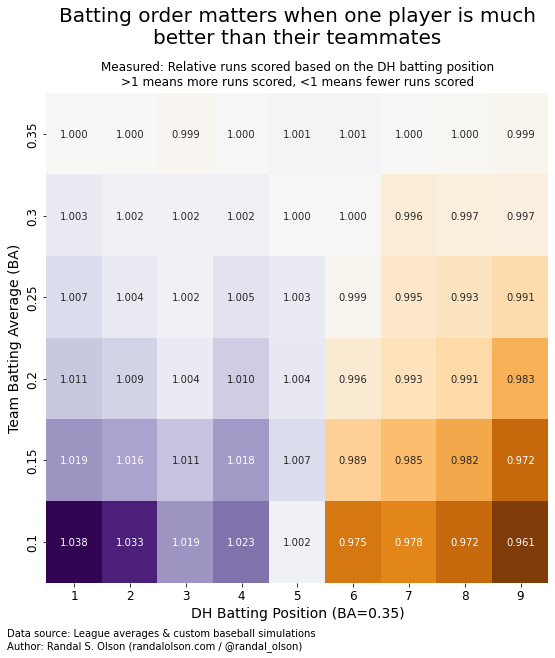

In [5]:
dh_batting_avgs = []
for team_avg in reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    dh_spot_avgs = []
    for designated_hitter_spot in range(9):
        dh_spot_avgs.append(np.mean(designated_hitter_spot_scores[(team_avg, designated_hitter_spot)]))
    dh_spot_avgs = np.array(dh_spot_avgs) / np.mean(dh_spot_avgs)
    dh_batting_avgs.append(dh_spot_avgs)

plt.figure(figsize=(9, 9))
sb.heatmap(dh_batting_avgs, cmap='PuOr', center=1., annot=True, fmt='.3f', cbar=False)
plt.xticks([x + 0.5 for x in range(9)], [str(x) for x in range(1, 10)], fontsize=12)
plt.xlabel('DH Batting Position (BA=0.35)', fontsize=14)
plt.yticks([y + 0.5 for y in range(6)], reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]), fontsize=12, va='center')
plt.ylabel('Team Batting Average (BA)', fontsize=14)
plt.title('Batting order matters when one player is much\nbetter than their teammates\n\n', fontsize=20)
plt.text(4.5, -0.1, 'Measured: Relative runs scored based on the DH batting position\n>1 means more runs scored, <1 means fewer runs scored', fontsize=12, ha='center')
plt.text(-0.7, 6.8, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
plt.savefig('mlb-batting-order-dh.png', bbox_inches='tight')
;

In [6]:
from scipy.stats import ranksums
from itertools import product

for team_avg1, designated_hitter_spot1, team_avg2, designated_hitter_spot2 in product([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9), [0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9)):
    if team_avg1 != team_avg2:
        continue
    if designated_hitter_spot1 > designated_hitter_spot2:
        continue
    if team_avg1 == team_avg2 and designated_hitter_spot1 == designated_hitter_spot2:
        continue
    statistic, pval = ranksums(designated_hitter_spot_scores[(team_avg1, designated_hitter_spot1)], designated_hitter_spot_scores[(team_avg2, designated_hitter_spot2)])
    if pval < 1e-5:
        print('sig diff: team avg={}, dh pos={} vs. dh pos={} [p={}]'.format(team_avg1, designated_hitter_spot1 + 1, designated_hitter_spot2 + 1, pval))


sig diff: team avg=0.1, dh pos=1 vs. dh pos=3 [p=1.4357847943527232e-30]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=4 [p=6.207996467340837e-31]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=5 [p=4.439641343509641e-101]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=6 [p=8.32432843805654e-238]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=7 [p=1.1909154670649897e-215]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=8 [p=6.027006296279137e-237]
sig diff: team avg=0.1, dh pos=1 vs. dh pos=9 [p=1.6763018288759153e-301]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=3 [p=3.1074740406162053e-15]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=4 [p=1.5790443958777603e-15]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=5 [p=2.802513264142209e-70]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=6 [p=1.7140931202184018e-188]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=7 [p=6.669269683735951e-169]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=8 [p=1.1043297948109777e-187]
sig diff: team avg=0.1, dh pos=2 vs. dh pos=9 [p=2

In [7]:
pitcher_spot_scores = {}
num_simulated_games = 1000000
for team_avg in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    for pitcher_spot in range(9):
        batters = [team_avg] * 9
        batters[pitcher_spot] = 0.1
        aprun = ParallelExecutor(n_jobs=-1, use_bar=False)
        pitcher_spot_scores[(team_avg, pitcher_spot)] = [runs_scored for runs_scored, _ in aprun(total=num_simulated_games)(delayed(simulate_game)(batters) for _ in ra

SyntaxError: unexpected EOF while parsing (<ipython-input-7-048681e9e70a>, line 8)

In [8]:
p_batting_avgs = []
for team_avg in reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    p_spot_avgs = []
    for pitcher_spot in range(9):
        p_spot_avgs.append(np.mean(pitcher_spot_scores[(team_avg, pitcher_spot)]))
    p_spot_avgs = np.array(p_spot_avgs) / np.mean(p_spot_avgs)
    p_batting_avgs.append(p_spot_avgs)

plt.figure(figsize=(9, 9))
sb.heatmap(p_batting_avgs, cmap='PuOr', center=1., annot=True, fmt='.3f', cbar=False)
plt.xticks([x + 0.5 for x in range(9)], [str(x) for x in range(1, 10)], fontsize=12)
plt.xlabel('Pitcher Batting Position (BA=0.1)', fontsize=14)
plt.yticks([y + 0.5 for y in range(6)], reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]), fontsize=12, va='center')
plt.ylabel('Team Batting Average (BA)', fontsize=14)
plt.title('Batting order matters when one player is much\nworse than their teammates\n\n', fontsize=20)
plt.text(4.5, -0.1, 'Measured: Relative runs scored based on the Pitcher batting position\n>1 means more runs scored, <1 means fewer runs scored', fontsize=12, ha='center')
plt.text(-0.7, 6.8, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
plt.savefig('mlb-batting-order-pitcher.png', bbox_inches='tight')
;

NameError: name 'pitcher_spot_scores' is not defined

In [9]:
from scipy.stats import ranksums
from itertools import product

for team_avg1, pitcher_spot1, team_avg2, pitcher_spot2 in product([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9), [0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9)):
    if team_avg1 != team_avg2:
        continue
    if pitcher_spot1 > pitcher_spot2:
        continue
    if team_avg1 == team_avg2 and pitcher_spot1 == pitcher_spot2:
        continue
    statistic, pval = ranksums(pitcher_spot_scores[(team_avg1, pitcher_spot1)], pitcher_spot_scores[(team_avg2, pitcher_spot2)])
    if pval < 1e-5:
        print('sig diff: team avg={}, pitcher pos={} vs. pitcher pos={} [p={}]'.format(team_avg1, pitcher_spot1 + 1, pitcher_spot2 + 1, pval))

NameError: name 'pitcher_spot_scores' is not defined

In [ ]:
hitter_spot_scores = {}
num_simulated_games = 1000000
for hitter_ba in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    for hitter_spot in range(9):
        batters = [0.25] * 9
        batters[hitter_spot] = hitter_ba
        aprun = ParallelExecutor(n_jobs=-1, use_bar=False)
        hitter_spot_scores[(hitter_ba, hitter_spot)] = [runs_scored for runs_scored, _ in aprun(total=num_simulated_games)(delayed(simulate_game)(batters) for _ in range(num_simulated_games))]


<ipython-input-10-3a3467613805>:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for hitter_ba in tqdm([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):


  0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
hitter_batting_avgs = []
for hitter_ba in reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]):
    hitter_spot_avgs = []
    for hitter_spot in range(9):
        hitter_spot_avgs.append(np.mean(hitter_spot_scores[(hitter_ba, hitter_spot)]))
    hitter_spot_avgs = np.array(hitter_spot_avgs) / np.mean(hitter_spot_avgs)
    hitter_batting_avgs.append(hitter_spot_avgs)

plt.figure(figsize=(9, 9))
sb.heatmap(hitter_batting_avgs, cmap='PuOr', center=1., annot=True, fmt='.3f', cbar=False)
plt.xticks([x + 0.5 for x in range(9)], [str(x) for x in range(1, 10)], fontsize=12)
plt.xlabel('Hitter Batting Position (Team BA=0.25)', fontsize=14)
plt.yticks([y + 0.5 for y in range(6)], reversed([0.1, 0.15, 0.2, 0.25, 0.3, 0.35]), fontsize=12, va='center')
plt.ylabel('Hitter Batting Average (BA)', fontsize=14)
plt.title('Exceptional batters should lead the batting line-up,\npoor batters should conclude the line-up\n\n', fontsize=20)
plt.text(4.5, -0.1, 'Measured: Relative runs scored based on the Hitter batting position & BA\n>1 means more runs scored, <1 means fewer runs scored', fontsize=12, ha='center')
plt.text(-0.7, 6.8, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
plt.savefig('mlb-batting-order-varying-hitter.png', bbox_inches='tight')
;

In [ ]:
from scipy.stats import ranksums
from itertools import product

for hitter_avg1, hitter_spot1, hitter_avg2, hitter_spot2 in product([0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9), [0.1, 0.15, 0.2, 0.25, 0.3, 0.35], range(9)):
    if hitter_avg1 != hitter_avg2:
        continue
    if hitter_spot1 > hitter_spot2:
        continue
    if hitter_avg1 == hitter_avg2 and hitter_spot1 == hitter_spot2:
        continue
    statistic, pval = ranksums(hitter_spot_scores[(hitter_avg1, hitter_spot1)], hitter_spot_scores[(hitter_avg2, hitter_spot2)])
    if pval < 1e-5:
        print('sig diff: batter avg={}, batter pos={} vs. batter pos={} [p={}]'.format(hitter_avg1, hitter_spot1 + 1, hitter_spot2 + 1, pval))

In [ ]:
batters = [0.25] * 9
num_simulated_games = 1000000
aprun = ParallelExecutor(n_jobs=-1, use_bar=False)
average_team_stats = [game_stats for _, game_stats in aprun(total=num_simulated_games)(delayed(simulate_game)(batters) for _ in range(num_simulated_games))]

In [ ]:
batting_stat = 'At Bat'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))

with plt.style.context('tableau10'):
    plt.figure()
    plt.bar(range(len(hitter_spot_avgs)), hitter_spot_avgs, color='#9467BD')
    batting_stat += 's per Game'
    plt.ylabel(batting_stat)
    plt.xticks(range(9), [str(x) for x in range(1, 10)])
    plt.xlabel('Batting Position')
    plt.title('Earlier batters have more At Bats on average')
    plt.text(-1.3, -0.75, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
    plt.savefig('mlb-batting-order-stats-{}.png'.format(batting_stat.replace(' ', '-')), bbox_inches='tight')
;

In [ ]:
batting_stat = 'At Bat'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))
hitter_spot_avgs

In [ ]:
batting_stat = 'Players On Base'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))

with plt.style.context('tableau10'):
    plt.figure()
    plt.bar(range(len(hitter_spot_avgs)), hitter_spot_avgs, color='#9467BD')
    batting_stat += ' per Game'
    plt.ylabel(batting_stat)
    plt.xticks(range(9), [str(x) for x in range(1, 10)])
    plt.xlabel('Batting Position')
    plt.title('Middle batters tend to have more players on base when batting')
    plt.text(-1.5, -0.4, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
    plt.savefig('mlb-batting-order-stats-{}.png'.format(batting_stat.replace(' ', '-')), bbox_inches='tight')
;

In [ ]:
batting_stat = 'RBI'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))

with plt.style.context('tableau10'):
    plt.figure()
    plt.bar(range(len(hitter_spot_avgs)), hitter_spot_avgs, color='#9467BD')
    batting_stat += ' per Game'
    plt.ylabel(batting_stat)
    plt.xticks(range(9), [str(x) for x in range(1, 10)])
    plt.xlabel('Batting Position')
    plt.title('Middle batters tend to contribute more RBI')
    plt.text(-1.6, -0.06, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
    plt.savefig('mlb-batting-order-stats-{}.png'.format(batting_stat.replace(' ', '-')), bbox_inches='tight')
;

In [ ]:
batting_stat = 'RBI'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))
hitter_spot_avgs

In [ ]:
batting_stat = 'Bases Loaded'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))

with plt.style.context('tableau10'):
    plt.figure()
    plt.bar(range(len(hitter_spot_avgs)), hitter_spot_avgs, color='#9467BD')
    batting_stat += ' per Game'
    plt.ylabel(batting_stat)
    plt.xticks(range(9), [str(x) for x in range(1, 10)])
    plt.xlabel('Batting Position')
    plt.title('The 6th batter is most likely to face a Bases Loaded situation')
    plt.text(-1.6, -0.013, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
    plt.savefig('mlb-batting-order-stats-{}.png'.format(batting_stat.replace(' ', '-')), bbox_inches='tight')
;

In [ ]:
batting_stat = 'Grand Slam'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))

with plt.style.context('tableau10'):
    plt.figure()
    plt.bar(range(len(hitter_spot_avgs)), hitter_spot_avgs, color='#9467BD')
    batting_stat += 's per Game'
    plt.ylabel(batting_stat)
    plt.xticks(range(9), [str(x) for x in range(1, 10)])
    plt.xlabel('Batting Position')
    plt.title('The 6th batter is most likely to hit a Grand Slam')
    plt.text(-1.85, -0.0005, 'Data source: League averages & custom baseball simulations\nAuthor: Randal S. Olson (randalolson.com / @randal_olson)', fontsize=10, ha='left')
    plt.savefig('mlb-batting-order-stats-{}.png'.format(batting_stat.replace(' ', '-')), bbox_inches='tight')
;

In [ ]:
batting_stat = 'Grand Slam'
hitter_spot_avgs = []
for hitter_spot in range(9):
    hitter_spot_avgs.append(np.mean([game_stats[hitter_spot][batting_stat] for game_stats in average_team_stats]))
hitter_spot_avgs